In [11]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from torchvision import models, datasets, transforms
from torchvision.models import EfficientNet_B0_Weights


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")


Training on device cpu


In [12]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels):
    classes=["Normal", "Cracked"]
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Defining Hyperparameters

In [13]:
train_dir = 'archive/training_data'
test_dir = 'archive/testing_data'

# Transformações de imagem
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Conjuntos de dados de treinamento e teste
train_set = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_set = datasets.ImageFolder(test_dir, transform=data_transforms['test'])


batch_size = 24
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# Carregar modelo pré-treinado EfficientNet-B0 e modificar a última camada
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features
model.fc = nn.Linear(num_features, 2)  # Ajustar para o número de classes do dataset

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Treinamento do modelo

In [14]:
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    start_time = time.time()
    
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    epoch_time = time.time() - start_time

    print(f'Epoch {epoch + 1}/{num_epochs} Epoch Loss: {epoch_loss:.4f} Epoch Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s')

Epoch 1/10 Epoch Loss: 1.8434 Epoch Acc: 0.7169 Time: 132.34s
Epoch 2/10 Epoch Loss: 0.2670 Epoch Acc: 0.9061 Time: 136.11s
Epoch 3/10 Epoch Loss: 0.1678 Epoch Acc: 0.9346 Time: 138.80s
Epoch 4/10 Epoch Loss: 0.1048 Epoch Acc: 0.9616 Time: 135.39s
Epoch 5/10 Epoch Loss: 0.0531 Epoch Acc: 0.9801 Time: 135.71s
Epoch 6/10 Epoch Loss: 0.0266 Epoch Acc: 0.9886 Time: 138.78s
Epoch 7/10 Epoch Loss: 0.0290 Epoch Acc: 0.9900 Time: 138.38s
Epoch 8/10 Epoch Loss: 0.1244 Epoch Acc: 0.9602 Time: 136.60s
Epoch 9/10 Epoch Loss: 0.0703 Epoch Acc: 0.9787 Time: 134.90s
Epoch 10/10 Epoch Loss: 0.0389 Epoch Acc: 0.9886 Time: 151.61s


In [15]:
# Salvar o modelo em um arquivo
torch.save(model.state_dict(), 'efficientnet_binary_fine_tuned.pth')

# Avaliação do modelo

Evaluation Results from Test Data
Average Loss: 0.9060678252611648
Accuracy: 0.7753846153846153
Precision: 0.6129032258064516
Recall: 0.991304347826087
F1 Score: 0.7574750830564784


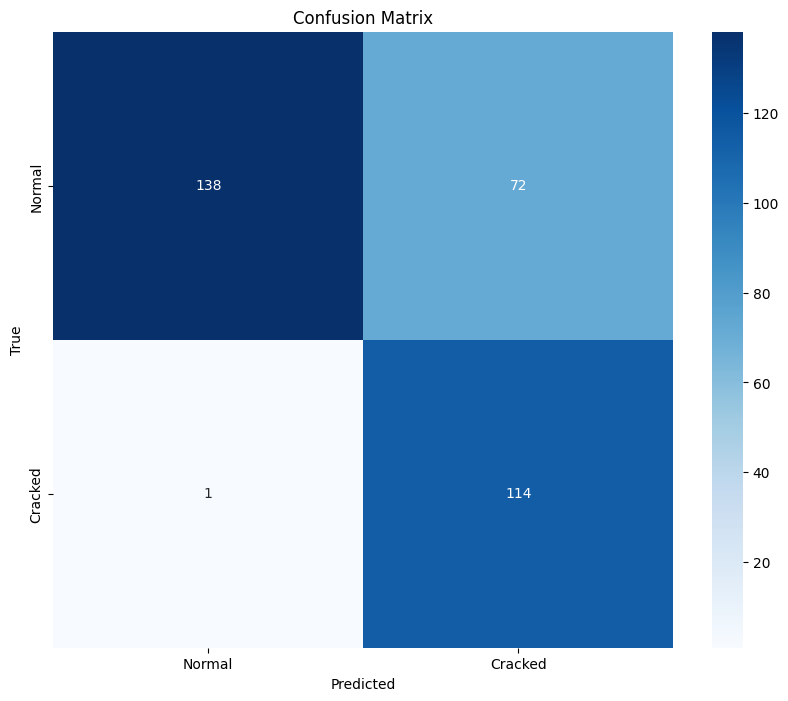

In [16]:
avg_loss, accuracy, precision, recall, f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)

print("Evaluation Results from Test Data")
print(f"Average Loss: {avg_loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)

In [17]:
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Cracked']))

              precision    recall  f1-score   support

      Normal       0.99      0.66      0.79       210
     Cracked       0.61      0.99      0.76       115

    accuracy                           0.78       325
   macro avg       0.80      0.82      0.77       325
weighted avg       0.86      0.78      0.78       325

